In [3]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import tensorflow as tf
import math
import time

import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import LeaveOneOut

In [39]:
# Import and organize data. Use only FSR data

filepath = "/Users/salatiemann/Documents/UC Berkeley/Year 3 Sem 2 (Spring 2020)/Tensegrity-HRI/Data_sala/test"
test_numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20',
      '21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40',
      '41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60',
      '61','62','63','64','65','66','67','68','69','70','71','72']
data = []
for num in test_numbers:
    filename = filepath + num + '.csv'
    d = pd.read_csv(filename, names = ["time", "IND", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", 
                                   "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12","ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d.drop(columns = ["IND", "time"])
    d1 = d1.drop(columns = ["ACC_X", "ACC_Y", "ACC_Z"])
    d1 = d1.to_numpy()
    d1 = d1[0:7000]
    data.append(d1)

In [5]:
np.shape(data)

(72, 7000, 12)

In [6]:
y = [0,0,0,3,1,1,1,1,1,1,3,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,1,1,1,1,0,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,2,3,3,3,3,3,2,2,2,0,0,1,1,2,2,3,3]

In [7]:
# This feature returns the percent of data points that are below 75% of the max

def three_quarters(column,percent):
    max = np.max(column)
    three_fourths = percent*max
    e = []
    j=0
    for i in range(len(column)):
        if column[i] <= .75*np.max(column):
            j+=1
    return j/len(column)

In [37]:
# This function takes all 72 data points of size (7001,16) and puts them into feature-engineered array (all features).
# Desired shape: 72 data points of size (6,16) --> (72,6,16)

def features(array, three_quarters_percent):
    len_dataset, _, number_of_columns = np.shape(array)
    number_of_features = 5
    featured_data = np.zeros((len_dataset,number_of_features,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((number_of_features,number_of_columns),dtype=np.float64)
        for i in range(number_of_columns):
            column = data_point[:,i]
            D[0,i] = np.mean(column)
            D[1,i] = np.var(column)
            D[2,i] = np.max(column)-np.min(column)
            D[3,i] = three_quarters(column,three_quarters_percent)
            D[4,i] = np.sum(column)/np.max(column) #or np.std(column). MAX WORKS THE BEST! went from 80% or so to 100%
        featured_data[j]=D
        if np.mod(j,6) == 0:
            print(j, end=" ")
    return featured_data

In [9]:
# Condense data into averages over a specified number of data points

def condense(array, condense_factor):
    len_dataset, _, number_of_columns = np.shape(array)
    length = len(array[0])
    condensed_length = int((length/condense_factor))
    condensed_data = np.zeros((len_dataset,condensed_length,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        for k in range(number_of_columns):
            column = data_point[:,k]
            for i in range(condensed_length):
                condensed_data[j][i,k] = np.mean(column[i*condense_factor:(i*condense_factor+condense_factor)])
    return condensed_data

In [10]:
# Takes the max of all features from the 16 datapoints. Output is 72 sets of 1 by 6 data, where each of the 6 points
# is the max of each feature from the set. 

def everything_max(array):
    len_dataset, num_features, num_datapoints = np.shape(array)
    maxed_data = np.zeros((len_dataset, 1, num_features))
    for i in range(len_dataset):
        datapoint = array[i]
        D = np.zeros((1, num_features))
        for j in range(num_features):
            D[0,j] = max(datapoint[:,j])
        maxed_data[i] = D
    return maxed_data

In [40]:
# Condense data by small factor (10)
data = condense(data,10)
data2 = data/np.max(data)

# Normalize and feature-ify the data
normalized_data = data/np.max(data)
normalized_featured_data = features(normalized_data,.8)
np.shape(normalized_featured_data)

0 6 12 18 24 30 36 42 48 54 60 66 

(72, 5, 12)

In [55]:
# Make dataset that only has max of each feature
maxed_data = everything_max(normalized_featured_data)

In [14]:
# Turn 3D array into 2D array
#np.shape(maxed_data)

In [15]:
# Turn 3D array into 2D array. Put features together later if possible?

def two_d(data):
    len_data, num_cols, num_points = np.shape(data)
    data_new = np.zeros((len_data, num_cols*num_points))
    for i in range(len_data):
        current = data[i]
        for j in range(num_cols):
            for k in range(num_points):
                data_new[i][num_points*j+k] = current[j][k]
    return data_new

In [16]:
def add_probs(array):
    new_probs = np.zeros((4, 4))
    for i in [0,2,4,6]:
        ind=np.int(i/2)
        for j in range(4):
            new_probs[ind][j] = array[i][j]+array[i+1][j]
    new_probs=np.transpose(new_probs)*100
    return new_probs/2

In [17]:
def train_xvalidation(data, num_train, num_est):
    
    # Split data into train, validation, and testing sets
    x = two_d(data)
    x_train, y_train = x[:num_train], y[:num_train]
    x_valid, y_valid = x[num_train:64], y[num_train:64]
    x_train_valid, y_train_valid = x[:64], y[:64]
    x_test, y_test = x[64:], y[64:]
    
    # Train uncalibrated random forest classifier on both train and validation data, evaluate on test data
    clf = RandomForestClassifier(n_estimators=num_est)
    clf.fit(x_train_valid, y_train_valid)
    clf_probs1 = clf.predict_proba(x_test)
    score = log_loss(y_test, clf_probs1)
    
    # Train random forest classifier, calibrate on validation data and evaluate on test data
    clf = RandomForestClassifier(n_estimators=num_est)
    clf.fit(x_train, y_train)
    clf_probs2 = clf.predict_proba(x_test)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(x_valid, y_valid)
    sig_clf_probs = sig_clf.predict_proba(x_test)
    sig_score = log_loss(y_test, sig_clf_probs)
    
    # Average probabilities
    clf_probs1 = add_probs(clf_probs1)
    clf_probs2 = add_probs(clf_probs2)
    sig_clf_probs = add_probs(sig_clf_probs)
    
    return clf_probs1, sig_clf_probs, clf_probs2, score, sig_score

In [18]:
def generate_plot(probability_array, title):
    N = 4
    label0 = probability_array[0]
    label1 = probability_array[1]
    label2 = probability_array[2]
    label3 = probability_array[3]

 
    # The position of the bars on the x-axis
    r = [0,1,2,3]
 
    # Names of group and bar width
    names = ['label0','label1','label2','label3']
    barWidth = 1
    
    plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
    plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
    plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
    plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
    plt.legend(('0 (node)', '1 (squeeze)','2 (drop)','3 (nothing)'))
 
    plt.xticks(r, names)
    plt.xlabel("true test value")
    plt.ylabel('Probability')
    plt.title(title)

In [19]:
# Compare normalized vs. non-normalized data with 100 estimators

clf_probs1,_,_,_,_ = train_xvalidation(data, 32, 100)
clf_probs2,_,_,_,_ = train_xvalidation(normalized_data, 32, 100)

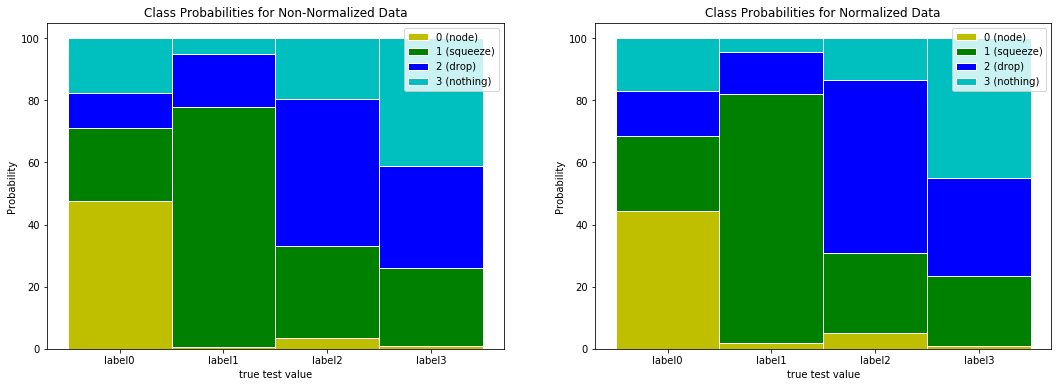

In [20]:
# Plot probabilities of normalized vs. non-normalized data

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(clf_probs1, "Class Probabilities for Non-Normalized Data")
plt.subplot(1, 2, 2)
generate_plot(clf_probs2, "Class Probabilities for Normalized Data")

In [35]:
# Compare feature-ified vs. non-feature-ified data

# non-featured data
clf_probs1,_,_,_,_ = train_xvalidation(normalized_data, 32, 100)

# featured data
clf_probs2,_,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

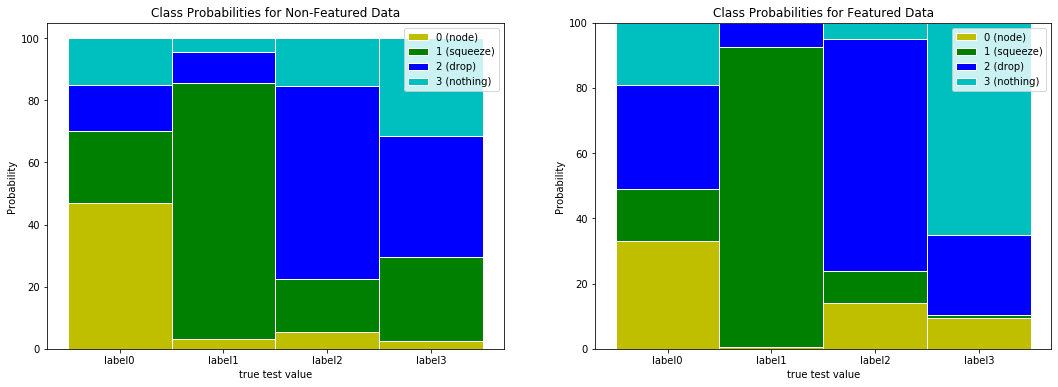

In [36]:
# Plot probabilities of non-featured vs. featured data

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(clf_probs1, "Class Probabilities for Non-Featured Data")
plt.subplot(1, 2, 2)
generate_plot(clf_probs2, "Class Probabilities for Featured Data")

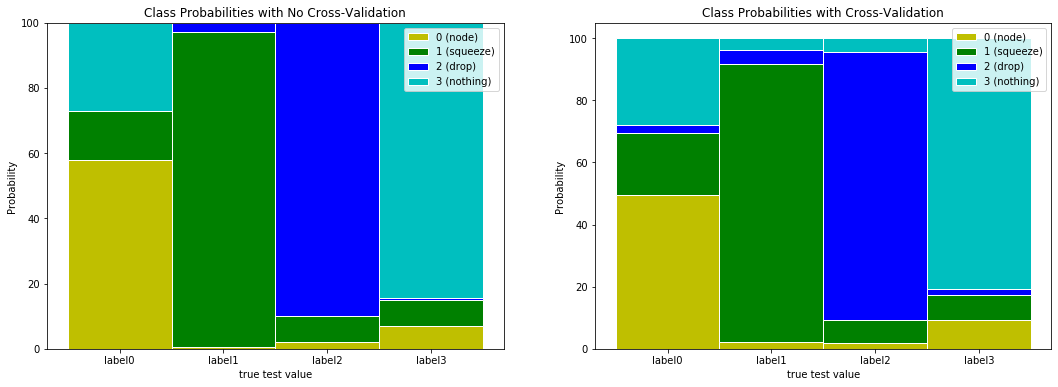

In [23]:
# Feature-engineered data: cross-validation vs. not
# This compares the classifier when trained on 64 data points and tested on the last 8 vs. when it is trained on 
# the first 32 data points, validated on the next 32 data points, and tested on the last 8

# Feature-engineered data. Get probabilities for uncalibrated classifier trained on both train and validation data
clf_probs1,_,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

# Feature-engineered data. Probabilities for random forest classifier calibrated on validation data and evaluated
# on test data
clf_probs2,sig_clf_probs,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

# Plot probabilities of cross-validation vs. no cross-validation

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(clf_probs1, "Class Probabilities with No Cross-Validation")
plt.subplot(1, 2, 2)
generate_plot(sig_clf_probs, "Class Probabilities with Cross-Validation")

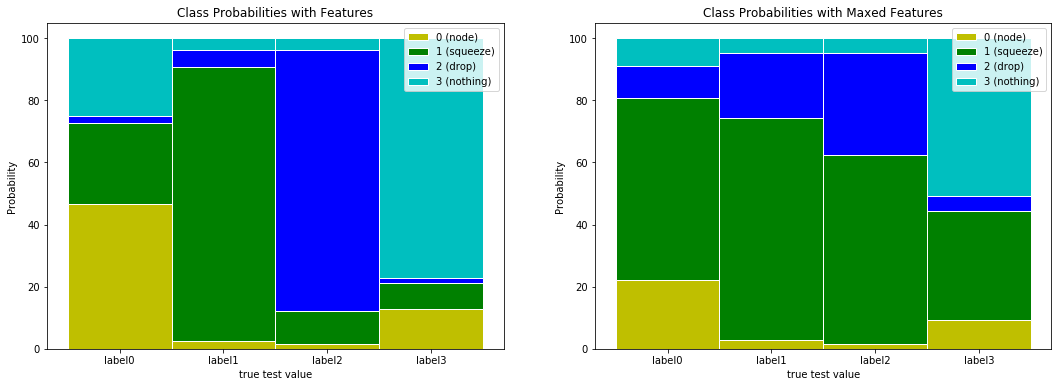

In [62]:
# Max features vs. all features

# Feature-engineered data. Get probabilities for uncalibrated classifier trained on both train and validation data
clf_probs1,sig_clf_probs1,_,_,_ = train_xvalidation(normalized_featured_data, 32, 100)

# Feature-engineered data. Probabilities for random forest classifier calibrated on validation data and evaluated
# on test data
clf_probs2,sig_clf_probs2,_,_,_ = train_xvalidation(maxed_data, 32, 100)

# Plot probabilities of cross-validation vs. no cross-validation

fig= plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
generate_plot(sig_clf_probs1, "Class Probabilities with Features")
plt.subplot(1, 2, 2)
generate_plot(sig_clf_probs2, "Class Probabilities with Maxed Features")

In [24]:
# Individual feature 

def one_feature(array, feature, three_quarters_percent=0):
    len_dataset, _, number_of_columns = np.shape(array)
    featured_data = np.zeros((len_dataset,1,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((1,number_of_columns),dtype=np.float64)
        if feature == "max":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D[0,i] = np.max(column)-np.min(column)
        if feature == "var":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D[0,i] = np.var(column)
        if feature == "mean":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D[0,i] = np.mean(column)
        if feature == "three quarters":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D[0,i] = three_quarters(column, three_quarters_percent)
            if np.mod(j,6) == 0:
                print(j, end=" ")
        if feature == "sum":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D[0,i] = np.sum(column)/np.max(column)
        featured_data[j]=D
    return featured_data

In [25]:
mean_data = one_feature(normalized_data, "mean")
var_data = one_feature(normalized_data, "var")

In [26]:
three_quarters_data = one_feature(normalized_data, "three quarters", .75)
sum_data = one_feature(normalized_data, "sum")

0 6 12 18 24 30 36 42 48 54 60 66 

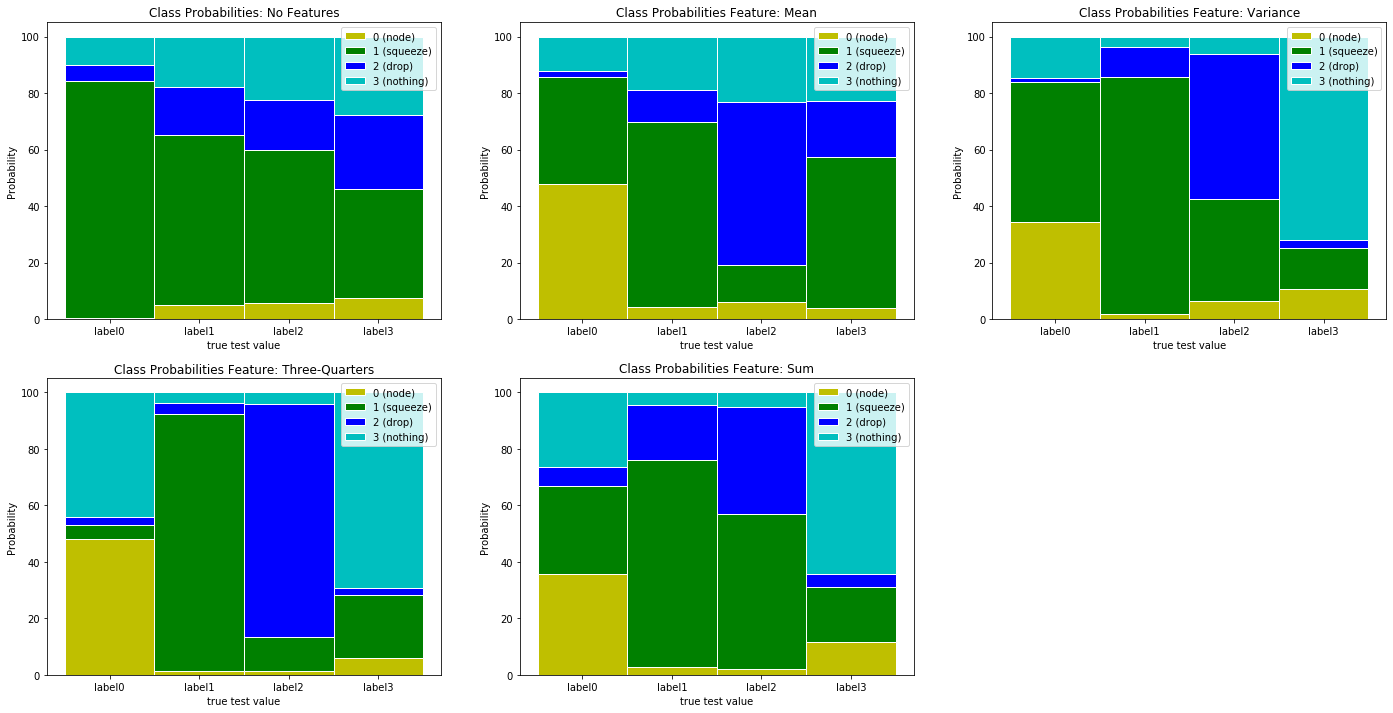

In [27]:
# Feature Comparison, including Cross-Validation

# No features
clf_probs1,sig_clf_probs1,_,_,_ = train_xvalidation(normalized_data, 32, 100)

# Feature: mean
clf_probs2,sig_clf_probs2,_,_,_ = train_xvalidation(mean_data, 32, 100)

# Feature: variance
clf_probs3,sig_clf_probs3,_,_,_ = train_xvalidation(var_data, 32, 100)

# Feature: three quarters (supposedly will distinguish drops from others) by finding out how many data points
# are less than or equal to 75% of the highest data point
clf_probs4,sig_clf_probs4,_,_,_ = train_xvalidation(three_quarters_data, 32, 100)

# Feature: sum
clf_probs5,sig_clf_probs5,_,_,_ = train_xvalidation(sum_data, 32, 100)

# Plot probabilities of various features

fig= plt.figure(figsize=(24,12))
plt.title('Comparison of Features')
plt.subplot(2,3,1)
generate_plot(sig_clf_probs1, "Class Probabilities: No Features")
plt.subplot(2,3, 2)
generate_plot(sig_clf_probs2, "Class Probabilities Feature: Mean")
plt.subplot(2,3,3)
generate_plot(sig_clf_probs3, "Class Probabilities Feature: Variance")
plt.subplot(2,3,4)
generate_plot(sig_clf_probs4, "Class Probabilities Feature: Three-Quarters")
plt.subplot(2,3,5)
generate_plot(sig_clf_probs5, "Class Probabilities Feature: Sum")

In [28]:
# Three-Quarters Comparison –– compare different three-quarter thresholds to determine if some are more helpful

# Condense data to speed up
condensed_data = condense(normalized_data, 10)

# Compare three-quarters values
thirty_data = one_feature(condensed_data, "three quarters", .30)
forty_data = one_feature(condensed_data, "three quarters", .40)
fifty_data = one_feature(condensed_data, "three quarters", .50)
sixty_data = one_feature(condensed_data, "three quarters", .60)
seventy_data = one_feature(condensed_data, "three quarters", .70)
eighty_data = one_feature(condensed_data, "three quarters", .80)
ninety_data = one_feature(condensed_data, "three quarters", .90)
ninety_nine_data = one_feature(condensed_data, "three quarters", .99)

0 6 12 18 24 30 36 42 48 54 60 66 0 6 12 18 24 30 36 42 48 54 60 66 0 6 12 18 24 30 36 42 48 54 60 66 0 6 12 18 24 30 36 42 48 54 60 66 0 6 12 18 24 30 36 42 48 54 60 66 0 6 12 18 24 30 36 42 48 54 60 66 0 6 12 18 24 30 36 42 48 54 60 66 0 6 12 18 24 30 36 42 48 54 60 66 

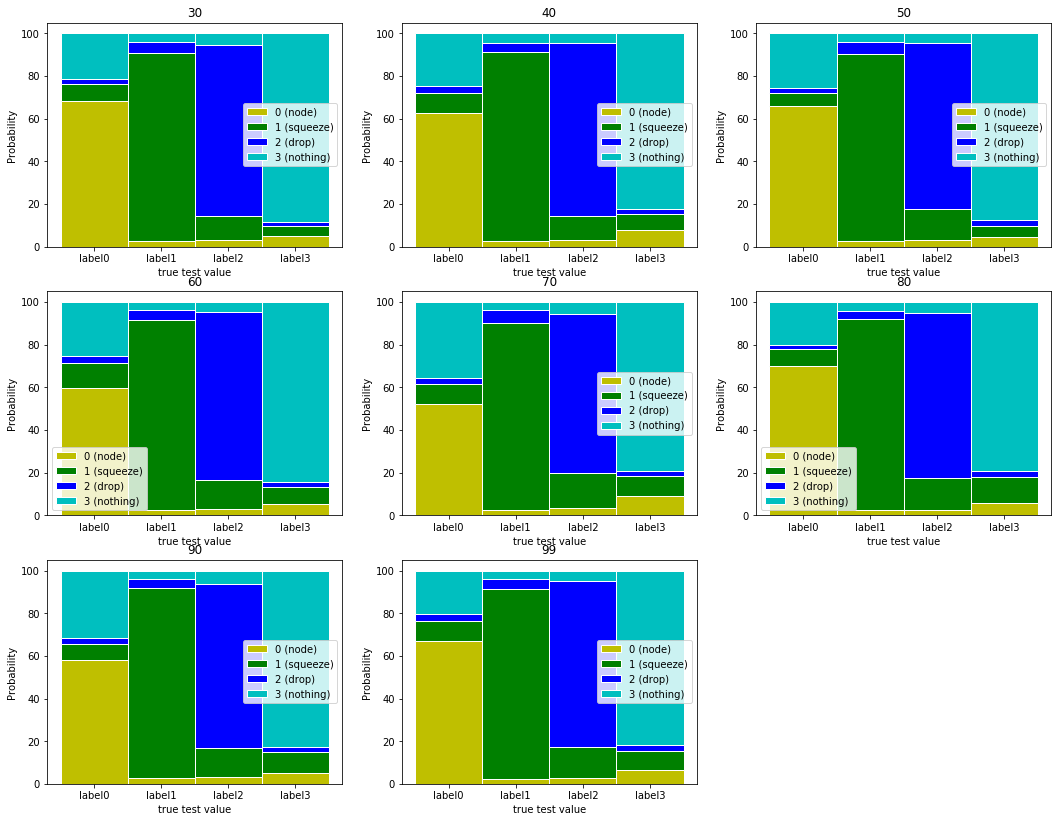

In [29]:
# Three-Quarters Comparison

clf_probs1,sig_clf_probs1,_,_,_ = train_xvalidation(thirty_data, 32, 100)
clf_probs2,sig_clf_probs2,_,_,_ = train_xvalidation(forty_data, 32, 100)
clf_probs3,sig_clf_probs3,_,_,_ = train_xvalidation(fifty_data, 32, 100)
clf_probs4,sig_clf_probs4,_,_,_ = train_xvalidation(sixty_data, 32, 100)
clf_probs5,sig_clf_probs5,_,_,_ = train_xvalidation(seventy_data, 32, 100)
clf_probs6,sig_clf_probs6,_,_,_ = train_xvalidation(eighty_data, 32, 100)
clf_probs7,sig_clf_probs7,_,_,_ = train_xvalidation(ninety_data, 32, 100)
clf_probs8,sig_clf_probs8,_,_,_ = train_xvalidation(ninety_nine_data, 32, 100)

fig= plt.figure(figsize=(18,14))
plt.title('Three-Quarters Comparison')
plt.subplot(3,3,1)
generate_plot(sig_clf_probs1, "30")
plt.subplot(3,3,2)
generate_plot(sig_clf_probs2, "40")
plt.subplot(3,3,3)
generate_plot(sig_clf_probs3, "50")
plt.subplot(3,3,4)
generate_plot(sig_clf_probs4, "60")
plt.subplot(3,3,5)
generate_plot(sig_clf_probs5, "70")
plt.subplot(3,3,6)
generate_plot(sig_clf_probs6, "80")
plt.subplot(3,3,7)
generate_plot(sig_clf_probs7, "90")
plt.subplot(3,3,8)
generate_plot(sig_clf_probs8, "99")

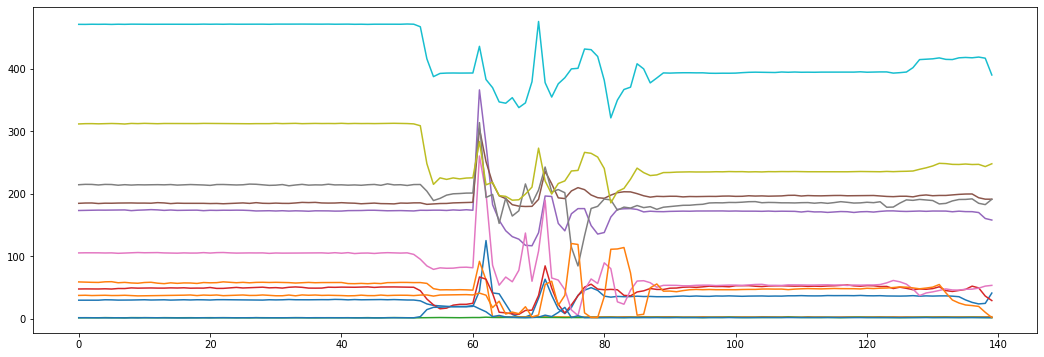

In [30]:
# Condense already condensed data by factors of 2, etc. 

condensed_data20 = condense(data,2)
condensed_data50 = condense(data,5)
condensed_data100 = condense(data,10)
condensed_data200 = condense(data,20)
condensed_data500 = condense(data,50)
plt.figure(figsize=(18,6))
plt.plot(condensed_data50[68])
plt.show()

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(condensed_data100[71])
plt.show

In [ ]:
def oscillation(col):
    length = np.size(col)
    D = np.array([0,col[0]])
    for i in range(1,length-1):
        if ((col[i] > col[i-1]) and (col[i]>col[i+1])) or ((col[i]<col[i-1]) and (col[i]<col[i+1])):
            D = np.vstack((D,[i, col[i]]))
    plt.plot(D[:,0],D[:,1],'o')
    return np.size(D)
    
#     a = np.array([[1, 2], [3, 4]])
# b = np.array([[5, 6]])
# np.concatenate((a, b), axis=0)
# array([[1, 2],
#        [3, 4],
#        [5, 6]])

In [ ]:
fig= plt.figure(figsize=(18,14))
plt.subplot(3,3,1)
oscillation(condensed_data200[1][:,3])
plt.subplot(3,3,2)
oscillation(condensed_data200[11][:,0])
plt.subplot(3,3,3)
oscillation(condensed_data200[21][:,0])
plt.subplot(3,3,4)
oscillation(condensed_data200[31][:,0])
plt.subplot(3,3,5)
oscillation(condensed_data200[41][:,0])
plt.subplot(3,3,6)
oscillation(condensed_data200[51][:,0])
plt.subplot(3,3,7)
oscillation(condensed_data200[61][:,0])
plt.subplot(3,3,8)
oscillation(condensed_data200[71][:,0])
plt.subplot(3,3,9)
oscillation(condensed_data200[36][:,0])

In [ ]:
plt.plot(condensed_data10[71][:,0])

In [ ]:
# Individual feature 

def one_feature(array, feature, three_quarters_percent=0):
    len_dataset, _, number_of_columns = np.shape(array)
    featured_data = np.zeros((len_dataset,1,number_of_columns))
    for j in range(len_dataset):
        data_point = array[j]
        number_of_columns = len(data_point[0,:])
        D = np.zeros((1,number_of_columns),dtype=np.float64)
        if feature == "oscillation":
            for i in range(number_of_columns):
                column = data_point[:,i]
                D[0,i] = oscillation(column)
        featured_data[j]=D
    return np.size(D)

In [ ]:
os_data = one_feature(normalized_data, "oscillation")

In [ ]:
os_data

In [ ]:
clf_probs1,sig_clf_probs1,_,_,_ = train_xvalidation(normalized_data, 32, 100)
clf_probs2,sig_clf_probs2,_,_,_ = train_xvalidation(os_data, 32, 100)

fig= plt.figure(figsize=(18,14))
plt.title('Three-Quarters Comparison')
plt.subplot(2,1,1)
generate_plot(sig_clf_probs1, "no feature")
plt.subplot(2,1,2)
generate_plot(sig_clf_probs2, "oscillation")

In [42]:
X = normalized_data
loo = LeaveOneOut()
loo.get_n_splits(X)

72

In [43]:
y = np.asarray(y)

In [54]:
# Leave one out cross validation

for train_index, test_index in loo.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Test: {}".format(y[test_index]), "results: {}".format(y_test), end= "        ")

Test: [0] results: [0]        Test: [0] results: [0]        Test: [0] results: [0]        Test: [3] results: [3]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [3] results: [3]        Test: [0] results: [0]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [1] results: [1]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [0] results: [0]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [2] results: [2]        Test: [1] 

In [ ]:
y_test